In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

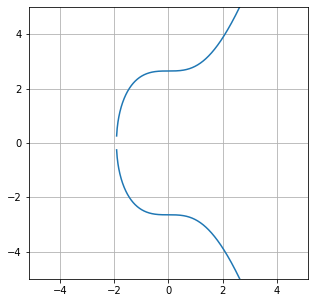

In [2]:
#
# Plotting curve
#   y^2 = x^3 + ax + b

# cf.
# https://en.wikipedia.org/wiki/Elliptic_curve
# https://github.com/bitcoin-core/secp256k1/blob/master/sage/secp256k1_params.sage


# TODO:
# better parameterization?

def _(a=0, b=7):
    import warnings
    lim = [-5, 5]
    num_samples = 1000
    x = np.linspace(*lim, num_samples)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', 'invalid value encountered in sqrt')
        y = (x ** 3 + a * x + b) ** 0.5    
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.grid()
    ax.axis('equal')
    ax.set(xlim=lim, ylim=lim)
    ax.plot(x, y, 'C0')
    ax.plot(x, -y, 'C0')


# ipyw.interact(_, a=(-10, 10, 0.1), b=(-10, 10, 0.05))

_()

In [3]:
# x^e (mod n)
def pow_mod(x, e, n):
    y = 1
    while e > 0:
        if e & 1:
            y = (y * x) % n
        x = (x * x) % n
        e = e >> 1
    return y


class MillerRabin():
    def __init__(self, seed="miller-rabin", num_trials=128):
        import random
        self.rng = random.Random(seed)
        self.num_trials = num_trials


    # x^(n - 1) != 1  =>  n is composite
    def test(self, x, k, q, n):
        y = pow_mod(x, q, n)
        if y == 1:
            return False
        for _ in range(k):
            if y == n - 1:
                return False
            y = (y * y) % n            
        return True


    def is_composite(self, n):
        from math import gcd
        
        assert n >= 0
        if n == 1 or n % 2 == 0:
            return False
        if n == 2:
            return True
        
        # n = 2^k q + 1
        q = n - 1
        k = 0
        while q % 2 == 0:
            q //= 2
            k += 1
            
        for _ in range(self.num_trials):
            x = self.rng.randrange(1, n)
            if gcd(x, n) != 1:
                return True
            if self.test(x, k, q, n):
                return True
        return False


    def is_prime(self, n):
        return not self.is_composite(n)


def factorize(n):
    from math import isqrt
    res = []
    for x in range(2, isqrt(n) + 1):
        while n % x == 0:
            n //= x
            res.append(x)
    if n > 1:
        res.append(n)
    return res

In [4]:
miller_rabin = MillerRabin()

for e in range(2, 32):
    n = 2 ** e - 1
    print(e, n, factorize(n), miller_rabin.is_prime(n))

2 3 [3] True
3 7 [7] True
4 15 [3, 5] False
5 31 [31] True
6 63 [3, 3, 7] False
7 127 [127] True
8 255 [3, 5, 17] False
9 511 [7, 73] False
10 1023 [3, 11, 31] False
11 2047 [23, 89] False
12 4095 [3, 3, 5, 7, 13] False
13 8191 [8191] True
14 16383 [3, 43, 127] False
15 32767 [7, 31, 151] False
16 65535 [3, 5, 17, 257] False
17 131071 [131071] True
18 262143 [3, 3, 3, 7, 19, 73] False
19 524287 [524287] True
20 1048575 [3, 5, 5, 11, 31, 41] False
21 2097151 [7, 7, 127, 337] False
22 4194303 [3, 23, 89, 683] False
23 8388607 [47, 178481] False
24 16777215 [3, 3, 5, 7, 13, 17, 241] False
25 33554431 [31, 601, 1801] False
26 67108863 [3, 2731, 8191] False
27 134217727 [7, 73, 262657] False
28 268435455 [3, 5, 29, 43, 113, 127] False
29 536870911 [233, 1103, 2089] False
30 1073741823 [3, 3, 7, 11, 31, 151, 331] False
31 2147483647 [2147483647] True


In [5]:
class TonelliShanks():
    def __init__(self, seed="tonelli-shanks"):
        import random
        self.rng = random.Random(seed) # For finding non quadratic residue

    # x^2 = y ∈ Z(p)
    def solve(self, y, p):
        y = y % p
        if y == 0 or p == 2:
            return y
        
        # p = 2^k q + 1 (odd prime)
        q = p - 1
        k = 0
        while q % 2 == 0:
            q //= 2
            k += 1

        # Euler's criterion
        if pow_mod(y, (p - 1) // 2, p) != 1:
            return None

        # Find non quadratic residue
        # z^((p - 1)/2) = -1
        while True:
            z = self.rng.randrange(1, p)
            if pow_mod(z, (p - 1) // 2, p) != 1:
                break

        # Tonelli Shanks algorithm

        # y^(q + 1) = y^q y = a y
        #           = (y^(q + 1)/2)^2 = b^2
        a = pow_mod(y, q, p)
        b = pow_mod(y, (q + 1) // 2, p)

        # y = (a^-1) b^2 = ((a^-1/2) b)^2
        # (accumulate the factor "a^-1/2" during the loop below)
        res = b 

        # a^(2^(k - 1)) = y^(q 2^(k - 1)) = y^((n - 1) / 2) = 1
        while a != 1:
            # Find t = min{i | a^(2^i) = 1} thus
            #   a^(2^t)     = 1
            #   a^(2^(t-1)) = -1            
            t = None
            d = a
            for i in range(1, k):
                d = (d * d) % p
                if d == 1:
                    t = i
                    break
            assert t is not None
            
            # Update "a" which leads to smaller "t" on the next loop
            # 1 = (-1)^2 
            #   = a^(2^(t-1)) z^((p-1)/2)
            #   = a^(2^(t-1)) z^(q 2^(k-1))
            #   = a^(2^(t-1)) (z^(q 2^(k-t-1))^2)^(2^(t-1))
            #   = (a w^2)^(2^(t-1))
            w = pow_mod(z, q * (2 ** (k - t - 1)), p)
            a = a * w % p * w % p
            res = res * w % p

        return res

In [6]:
#
# secp256k1
#
p = 2 ** 256 - 2 ** 32 - 977
miller_rabin = MillerRabin()
assert miller_rabin.is_prime(p)

a, b = 0, 7
f = lambda x: x ** 3 + a * x + b

tonelli_shanks = TonelliShanks()
x_to_y = lambda x: tonelli_shanks.solve(f(x), p)

gx = 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798
gy = x_to_y(gx)
assert (gy ** 2) % p == f(gx) % p

g = (gx, gy)

# TODO
# - How to compute order of g?
# - How to compute group structure?